In [57]:
import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import random

In [58]:
batch_size = 32  # how many samples per batch to load
iid = 0 # if the data is i.i.d or not
unbalanced = 1 # in non i.i.d. setting split the data between clients equally or not
num_users = 100 # number of client

In [59]:
if iid:
    from utils_v2 import get_dataset, average_weights, exp_details
else:
    from utils import get_dataset, average_weights, exp_details

In [60]:
# for REPRODUCIBILITY https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(1)

g = torch.Generator()
g.manual_seed(1)

np.random.seed(1)

In [61]:
train_dataset, test_dataset, user_groups = get_dataset(iid=iid, unbalanced=unbalanced,
                                                       num_users=num_users)

Files already downloaded and verified
Files already downloaded and verified


In [62]:
class DatasetSplit(Dataset):
    """
    An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [63]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [64]:
def get_dataloader(dataset, idxs):
    trainloader = DataLoader(DatasetSplit(dataset, idxs),
                             batch_size=batch_size, shuffle=True, generator=g,
                             worker_init_fn=seed_worker)

    return trainloader

In [65]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [66]:
user_lables = dict()
user_mean = dict()
user_std = dict()

for idx in user_groups.keys():
    labels_list = []
    #trainloader, _ = get_dataloader(train_dataset, user_groups[idx])
    trainloader = get_dataloader(train_dataset, user_groups[idx])
    mean = 0.0
    std = 0.0
    for data, target in trainloader:
        for i in range(len(data)):
            label = target.data[i]
            labels_list.append(classes[int(label)])

        # compute mean and std variation
        images = data.view(data.size(0), data.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(trainloader.dataset)
    std /= len(trainloader.dataset)

    user_mean[idx] = mean.numpy()
    user_std[idx] = std.numpy()

    user_lables[idx] = labels_list

C:\Users\david\AppData\Local\Temp\ipykernel_27528\3803027819.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


In [67]:
user_std[0]

array([1.2781734, 1.2977357, 1.2987704], dtype=float32)

In [68]:
def count_labels(user_labels, classes):
    user_labels_count = dict()
    for idx in user_groups.keys():
        elements_count = {}
        # iterating over the elements for frequency
        for element in user_labels[idx]:
            # checking whether it is in the dict or not
            if element in elements_count:
                # incerementing the count by 1
                elements_count[element] += 1
            else:
                # setting the count to 1
                elements_count[element] = 1

        user_labels_count[idx] = elements_count

    return user_labels_count

user_labels_count = count_labels(user_lables, classes)

In [69]:
import pandas as pd

data = pd.DataFrame.from_dict(user_labels_count, orient="index")

In [70]:
data.sum()

bird          5000.0
automobile    5000.0
airplane      5000.0
dog           5000.0
cat           5000.0
truck         5000.0
horse         5000.0
frog          5000.0
ship          5000.0
deer          5000.0
dtype: float64

In [71]:
data

,bird,automobile,airplane,dog,cat,truck,horse,frog,ship,deer
0,50.0,100.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100.0,50.0,200.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN
4,50.0,100.0,NaN,NaN,100.0,NaN,NaN,100.0,NaN,NaN
5,150.0,50.0,NaN,NaN,50.0,NaN,NaN,100.0,50.0,NaN
7,50.0,100.0,150.0,NaN,50.0,50.0,50.0,NaN,50.0,50.0
...,...,...,...,...,...,...,...,...,...,...
80,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,50.0
98,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN


Text(0.5, 0, 'Users')

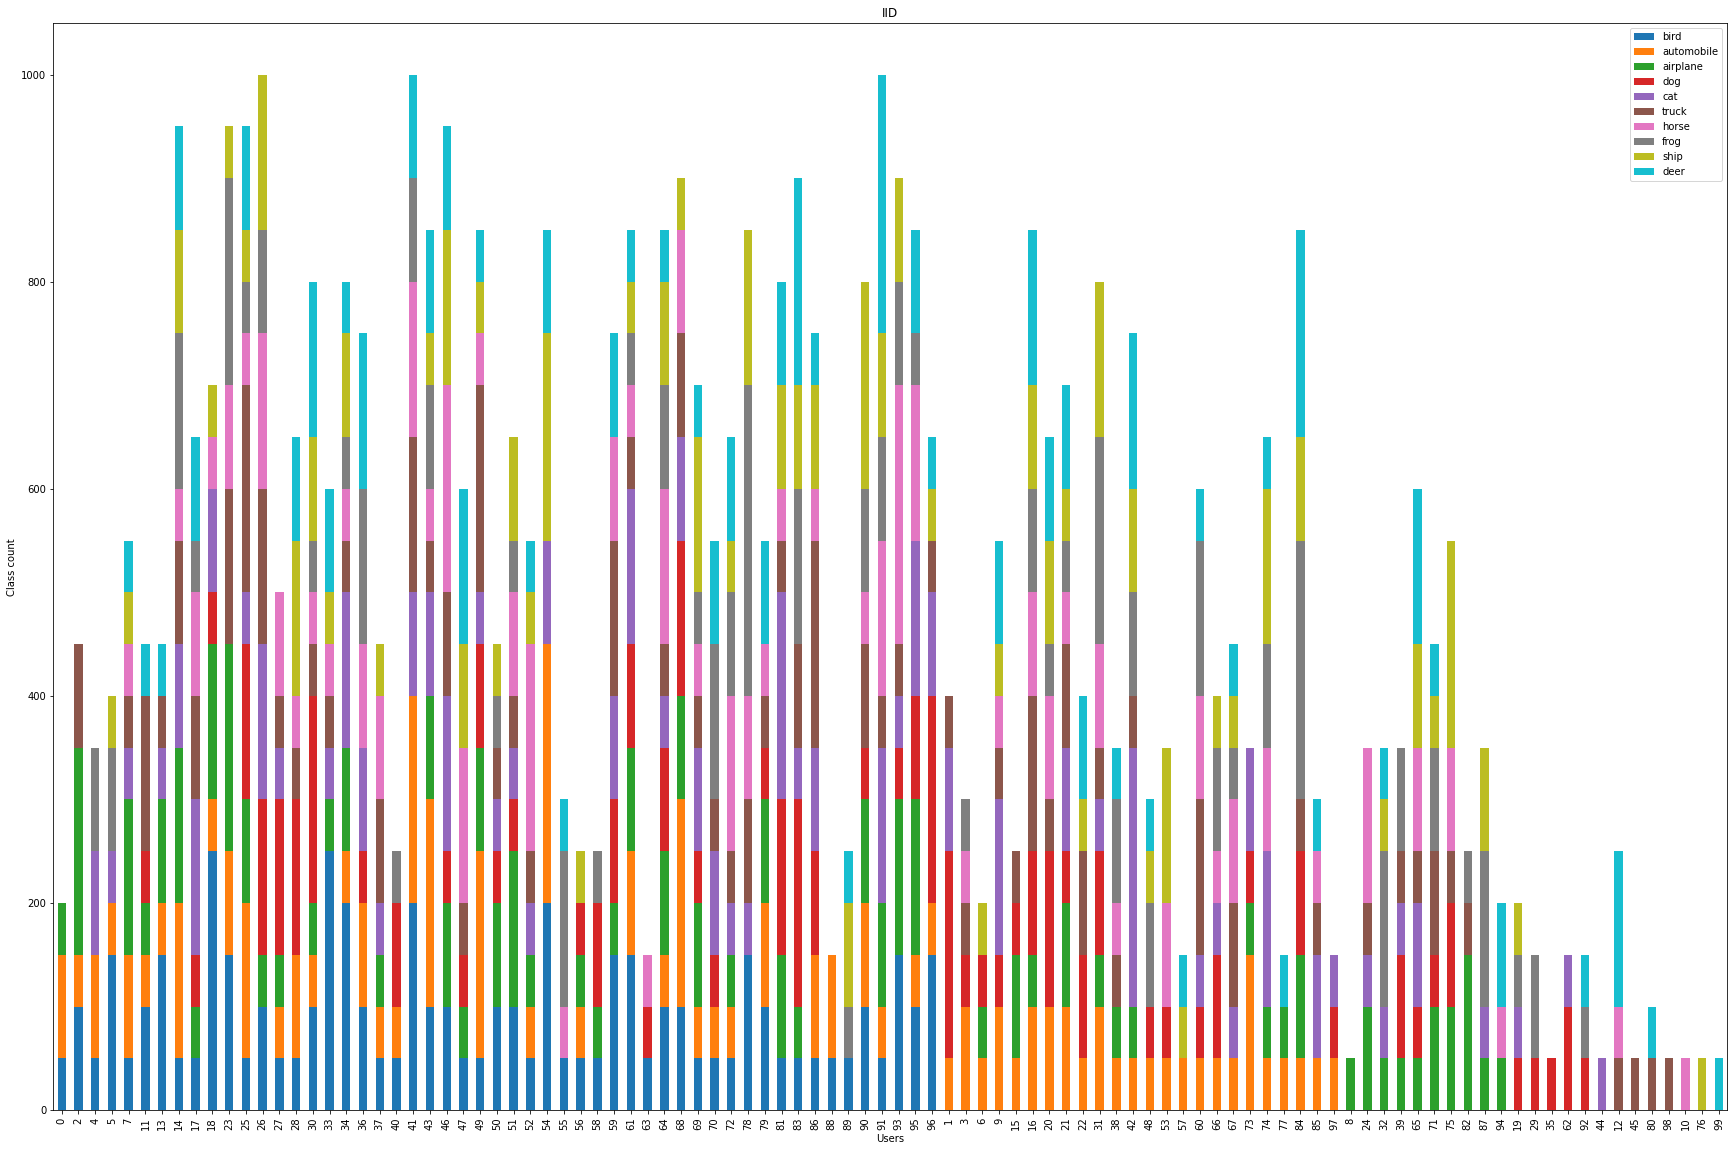

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 20))

data.plot.bar(stacked=True, ax=ax)

plt.title("IID")
plt.ylabel('Class count')
plt.xlabel('Users')

# plt.savefig("data_distribution/new_random_seed/test.png")

In [73]:
images_each_user = [ len(user_groups[idx]) for idx in user_groups.keys() ]
print(np.mean(images_each_user))
print(np.std(images_each_user))

500.0
285.13154858766507


In [74]:
# means = [ user_groups[idx].sum() for idx in user_groups.keys() ]
# stds = [ user_groups[idx].sum() for idx in user_groups.keys() ]

In [75]:
# fig, ax = plt.subplots(figsize=(10,7))
# x = list(user_labels_count.keys())
#
# plt.errorbar(x, means, stds)

In [76]:
# fig, ax = plt.subplots(figsize=(10,7))
#
# y = list(user_mean.values())
# e = list(user_std.values())
# x = list(user_labels_count.keys())
#
# y1 = [i[0]+5 for i in y]
# e1 = [i[0] for i in e]
# y2 = [i[1] for i in y]
# e2 = [i[1] for i in e]
# y3 = [i[2]-5 for i in y]
# e3 = [i[2] for i in e]
#
# plt.errorbar(x, y1, e1, color="r")
# plt.errorbar(x, y2, e2, color="g")
# plt.errorbar(x, y3, e3, color="b")